# Plots

In [1]:
import src.utilities.plot as my_plt
import src.apds.docsim_sequential as ds_seq
import src.apds.docsim_mapreduce_spark as ds_mr

## sequential

In [2]:
seq_results = ds_seq.load_results('../../data/trec-covid/samples_400/seq_result/seq_results.pkl')
seq_results_h = ds_seq.load_results('../../data/trec-covid/samples_400/seq_result/seq_results_h.pkl')

In [ ]:
my_plt.plot_results_seq(results_n=seq_results, results_h=seq_results_h) #longest_docs, shortest_docs, random_docs

## parallel

In [2]:
mr_results = ds_mr.load_mr_results('../../data/trec-covid/samples_400/mr_result/mr_results.pkl')
mr_results_h = ds_mr.load_mr_results('../../data/trec-covid/samples_400/mr_result/mr_results_h.pkl')

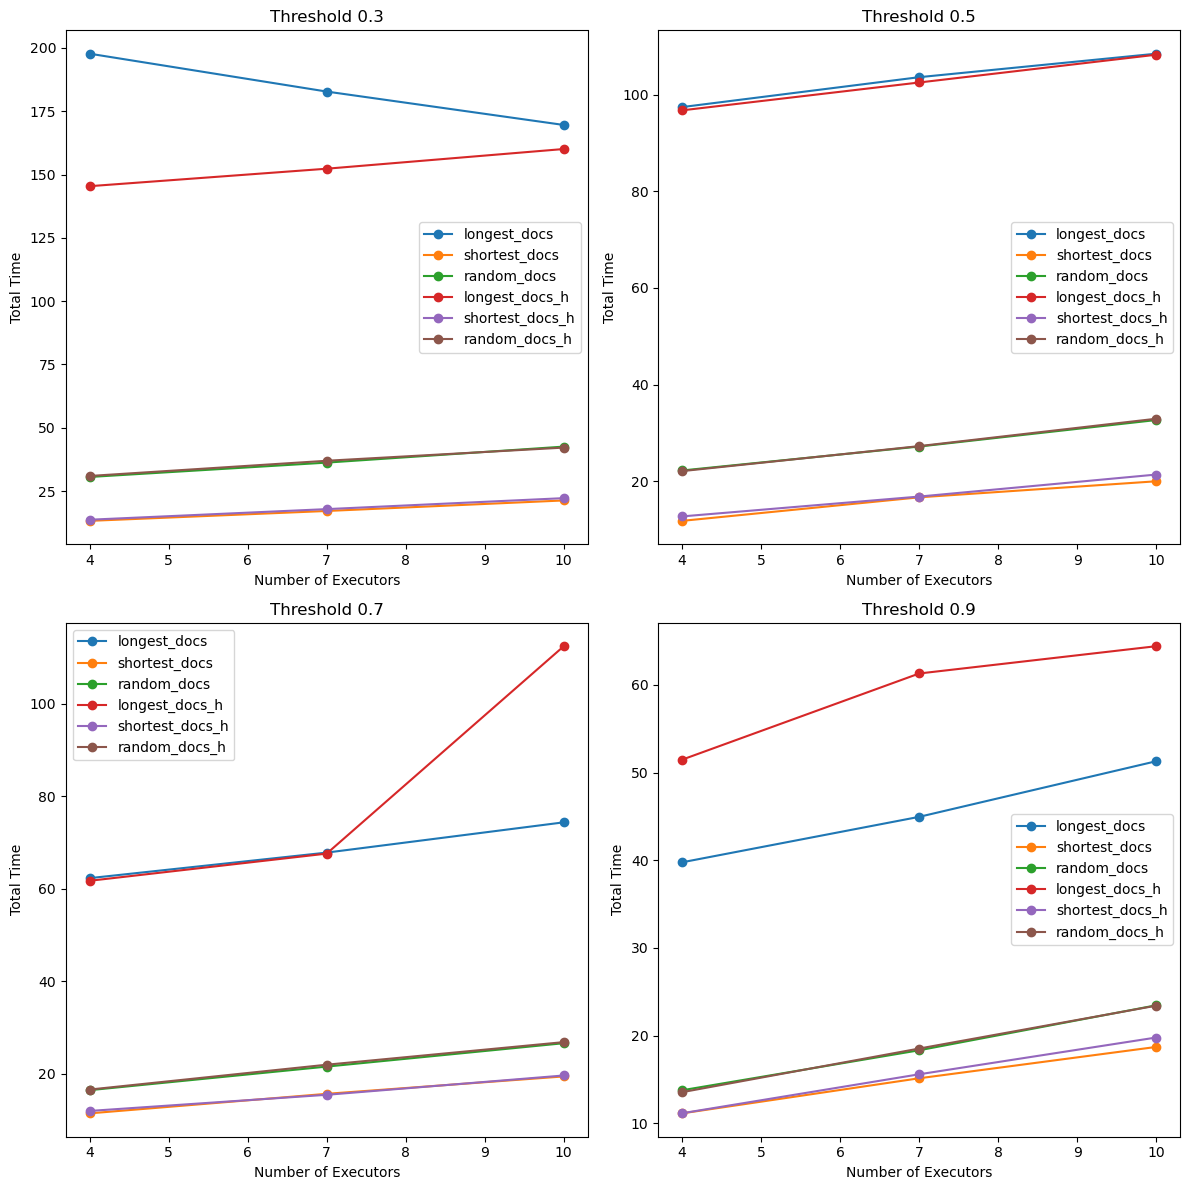

In [3]:
my_plt.plot_results_mr(results_n=mr_results, results_h=mr_results_h) #longest_docs, shortest_docs, random_docs

# TODO
- sistemare e commenti notebook and file
- see proportion of time in execution to simulate 1000 doc (run sequential with 1000, parallel 500 then proportionate)
- i already have 1000 ran, so just set to 1000 and load time taken and see if a x2 is enough (sequential just plot 1000, parallel 500 x2 maybe not i will see)
- finire report (parallelo, risultati)